
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas as pd #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

I will be working with Linh Dinh and Lily Grier, this pitch was developed in collaboration with them.

Cell 2:

# ***What?*** 
<200 words

Cell 3:

## ***Why?***
<200 words

Cell 4:

## ***How?***
Cell 5:

We plan to break our investigation into a series of pieces to understand the semantic relationship between executive orders and presidential speeches. 
- The first step which we already completed was to compile the corpus through web-scraping. We did two web-scraping modules to generate a corpus of presidential speeches and a corpus on executive orders.
- We have pre-processed the text by removing white space, non-alpha numeric characters as well as lemmatizing, removing stop words and tokenizing each of the documents present in our corpus.
- With the pre-processed corpus we will then use semantic analysis including dependency parsing, POS tagging and collocation analysis to understand the patterns and characteristics unique to speeches and orders across various dimensions including party affiliation, president, year of event, etc. 
- In addition, we will use sentiment analysis and POS tagging to understand the sentiment different presidents use towards specific named entities such as organizations and types of regulations.
- We will then convert our documents into vector form through a count or tf-idf vectorizer.
- We will apply both hard clustering methods (k-means, hierarchical clustering and DBSCAN) to understand what features present in our corpus best divide documents into different clusters.
- Once we understand the emergence and distribution of clusters in our data we will use classification in order to understand what are the best predictors of successful execute orders (those which are not revoked). 
- Finally, we will digest the results of our previous analysis to understand how presidential speeches and executive orders interact, the dynamics among different presidents and the adversarial or collaborative relationship among them.


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***

We are studying the executive branch of government, how it communicates about its goals, purposes and actions with the public and how it tries to achieve some of these goals through executive orders. Furthermore, we are investigating the dynamics between various occupants of the oval office how their unique use of language, party affiliation and time in office differentiate them. Our analysis is limited in that we are only using executive orders for legislation while during their terms presidents pass much more legislation through various means in addition to these orders. 
Furthermore, our work seeks to make inferences about the political class in the United States the role they play in a democratic society and the impact that their spoken speech has on one specific sort of legislation. Our analysis is further limited on the politicians represented in our corpus, we are only including presidents, however future work could expand on our work and include other elected officials. In addition, further research could expand on our work and include more official communications such as press releases, social media activity as well as other legislative efforts in order to have a more expansive and exhaustive understanding of the relationship between presidential rhetoric and legislation.


# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [2]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [3]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [6]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pd.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pd.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


text               category  \
0  \tIn certain Apple 13" RGB monitors there has ...  comp.sys.mac.hardware   
1  Does anyone know how to reach Micron?  I am in...  comp.sys.mac.hardware   
2  Hi there!\n\nCould some kind soul tell me what...  comp.sys.mac.hardware   
3                                        "auto\nfrom  comp.sys.mac.hardware   
4  \n\n    Don't believe the hype. There is no su...  comp.sys.mac.hardware   
5  What is the value of an SE (HDFD) 4/20?\n\n-David  comp.sys.mac.hardware   
6  \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...  comp.sys.mac.hardware   
7  \n\n\n    Nope. The Apple 16" monitor does not...  comp.sys.mac.hardware   
8  \n\nIs it a hidden option?  I'm using PowerStr...  comp.sys.mac.hardware   
9  \n\n\nThe previous article referred to the fac...  comp.sys.mac.hardware   

                                         source_file  
0  ../data/scikit_learn_data/20news_home/20news-b...  
1  ../data/scikit_learn_data/20news_home/20news-b...  
2  ../data/scikit_learn_data/20news_home/20news-b...  
3  ../data/scikit_learn_data/20news_home/20news-b...  
4  ../data/scikit_learn_data/20news_home/20news-b...  
5  ../data/scikit_learn_data/20news_home/20news-b...  
6  ../data/scikit_learn_data/20news_home/20news-b...  
7  ../data/scikit_learn_data/20news_home/20news-b...  
8  ../data/scikit_learn_data/20news_home/20news-b...  
9  ../data/scikit_learn_data/20news_home/20news-b...

Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [6]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


I'm pretty sure that you're very familiar with the cell above now, but let's go through the concepts again. 

What do we want to do here? We want to do vectorization, i.e., converting texts into numerical features (vectors) as required by machine learning algorithms. And this is what feature_extraction module does: to extract features from texts in a format as required by ML algorithms. feature_extraction module has four classes: CountVectorizer, DictVectorizer, TfidfVectorizer, and FeatureHasher. Here, we use CountVectorizer, but we'll also use TfidfVectorizer as well below.

There are various strategies by which we extract features. Here, we use CountVectorizer, and, in particular, we use 'Bag of Words' representation. In other words, the features we hope to extract from the texts are each individual token occurrence frequency. We simply count the the occurrence of each token in each document. So, here, we get a document-term-matrix, in which documents are characterized by the occurrences of tokens. Other forms of features, such as the relative position information of words, are ignored. We'll see other types of representations and strategies as well soon, such as N-gram (by the way, we can do n-gram with CountVectorizer. CountVectorizer class takes a set of parameters, such as analyzer, which you can specify the n-gram). 

the first line of the cell above instantiate a class, CountVectorizer(). In other words, you created an instance, or realization of a class. What is a class and what does instantiation mean? That's a long story, maybe for next time.

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [7]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [8]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

What is the toarray() function here? It's similar to todense()--todense() and toarray() both returns a dense representation of a matrix; however, todense() returns a matrix representation while toarray() returns a ndarray representation.

We can also lookup the indices of different words using the Vectorizer

In [9]:
ngCountVectorizer.vocabulary_.get('vector')

21647

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [10]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


This gives us the tf-idf for each word in each text

In [11]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

[('in', 0.08265545268171724),
 ('certain', 0.05464092321093494),
 ('apple', 0.19706119834212132),
 ('13', 0.05749878121929968),
 ('rgb', 0.07820822067701588),
 ('monitors', 0.0749569030656185),
 ('there', 0.10567912764152107),
 ('has', 0.1109950967372947),
 ('been', 0.05330795380898169),
 ('problem', 0.21470375597395805),
 ('with', 0.09901319943986409),
 ('the', 0.19389877721110985),
 ('high', 0.1817286448065436),
 ('voltage', 0.19389877721110985),
 ('capasitor', 0.33279218254193177),
 ('knows', 0.18819404816424326),
 ('about', 0.08243502153417578),
 ('this', 0.1619412292430009),
 ('and', 0.13074268623716792),
 ('is', 0.16299450361806797)]

Let's see what we're doing here. First, you need to know what vocabulary\_ does. vocabulary\_ is an attribute of the CountVectorizer, which gives you a mapping of terms to feature indices. It gives you all the terms and their feature indices, so it's a dictionary. So, by doing "ngCountVectorizer.vocabulary\_.keys()", we get the keys of the dictionary, which are the terms. 

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [12]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [13]:
newsgroupsDF['text']

0       \tIn certain Apple 13" RGB monitors there has ...
1       Does anyone know how to reach Micron?  I am in...
2       Hi there!\n\nCould some kind soul tell me what...
3                                             "auto\nfrom
4       \n\n    Don't believe the hype. There is no su...
                              ...                        
2345    I was wondering if anyone out in net-land have...
2346    \n\n\n\n\nI sold my '86 Sprint last April with...
2347    Actually I wasn't too surprised, since I bough...
2348    \n\nI couldnt agree more.  That is how it SHOU...
2349    \nWarren Brown, the Washington Post's auto wri...
Name: text, Length: 2350, dtype: object

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [14]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['certain', 'apple', '13', 'monitors', 'problem', 'high', 'cost', 'bad', 'got', 'local'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [15]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

4

Then we can initialize our cluster finder

In [16]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [17]:
km.fit(newsgroupsTFVects)

KMeans(n_clusters=4)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [18]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

The available metrics are: ['ConfusionMatrixDisplay', 'DetCurveDisplay', 'PrecisionRecallDisplay', 'RocCurveDisplay', 'SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'brier_score_loss', 'calinski_harabasz_score', 'check_scoring', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'dcg_score', 'det_curve', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_gamma_deviance', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_l

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [20]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

text  \
0     \tIn certain Apple 13" RGB monitors there has ...   
1     Does anyone know how to reach Micron?  I am in...   
2     Hi there!\n\nCould some kind soul tell me what...   
3                                           "auto\nfrom   
4     \n\n    Don't believe the hype. There is no su...   
...                                                 ...   
2345  I was wondering if anyone out in net-land have...   
2346  \n\n\n\n\nI sold my '86 Sprint last April with...   
2347  Actually I wasn't too surprised, since I bough...   
2348  \n\nI couldnt agree more.  That is how it SHOU...   
2349  \nWarren Brown, the Washington Post's auto wri...   

                   category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
...                     ...   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  kmeans_predictions  
0     ../data/scikit_learn_data/20news_home/20news-b...                   0  
1     ../data/scikit_learn_data/20news_home/20news-b...                   0  
2     ../data/scikit_learn_data/20news_home/20news-b...                   0  
3     ../data/scikit_learn_data/20news_home/20news-b...                   0  
4     ../data/scikit_learn_data/20news_home/20news-b...                   0  
...                                                 ...                 ...  
2345  ../data/scikit_learn_data/20news_home/20news-b...                   0  
2346  ../data/scikit_learn_data/20news_home/20news-b...                   2  
2347  ../data/scikit_learn_data/20news_home/20news-b...                   2  
2348  ../data/scikit_learn_data/20news_home/20news-b...                   0  
2349  ../data/scikit_learn_data/20news_home/20news-b...                   0  

[2350 rows x 4 columns]

We can also look at the distinguishing features in each cluster:

In [21]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 thanks
 know
 mac
 just
 does
 like
 drive
 apple
 don
 problem


Cluster 1:
 sale
 00
 offer
 shipping
 condition
 new
 asking
 interested
 price
 email


Cluster 2:
 car
 cars
 engine
 like
 just
 good
 think
 don
 new
 dealer


Cluster 3:
 window
 server
 motif
 use
 widget
 program
 application
 using
 code
 running




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [22]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [23]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [24]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('comp.sys.mac.hardware', 'red'), ('comp.windows.x', 'orange'), ('misc.forsale', 'green'), ('rec.autos', 'blue')])


Let's plot the data using the true labels as the colors of our data points.

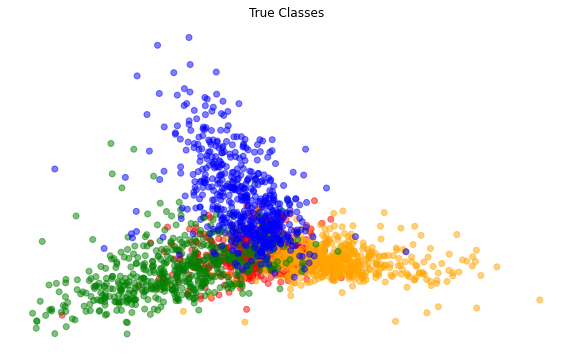

In [25]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

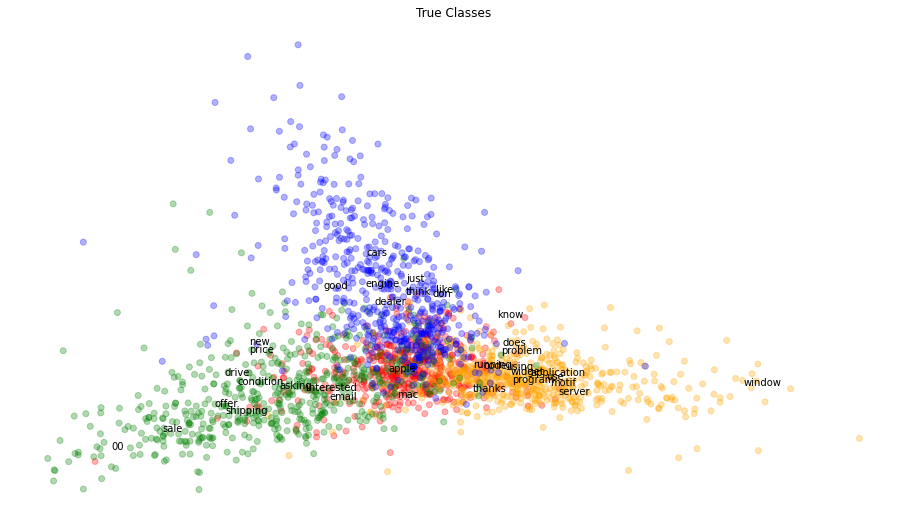

In [26]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

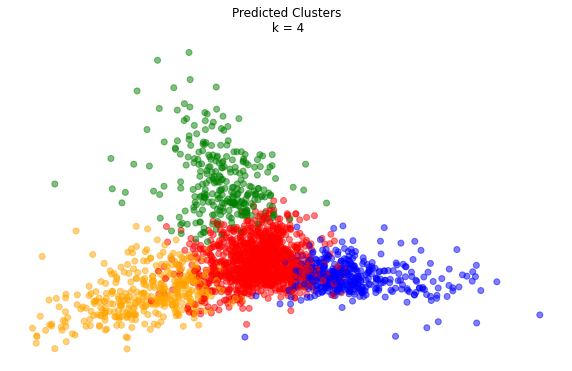

In [28]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

In [27]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

Let's try with 3 clusters.

In [29]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

KMeans(n_clusters=3)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [24]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


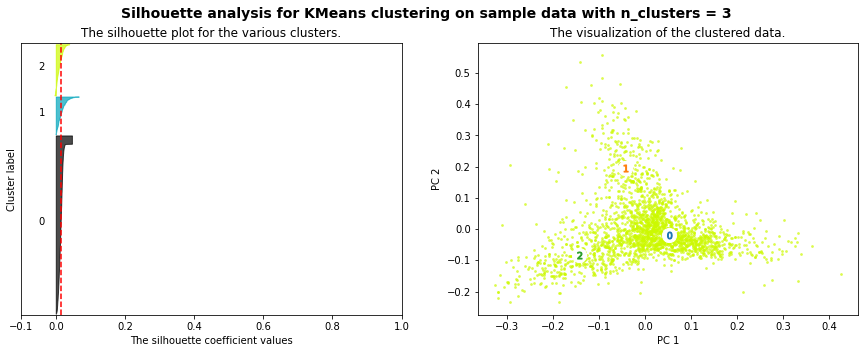

For n_clusters = 3, The average silhouette_score is : 0.014


In [31]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


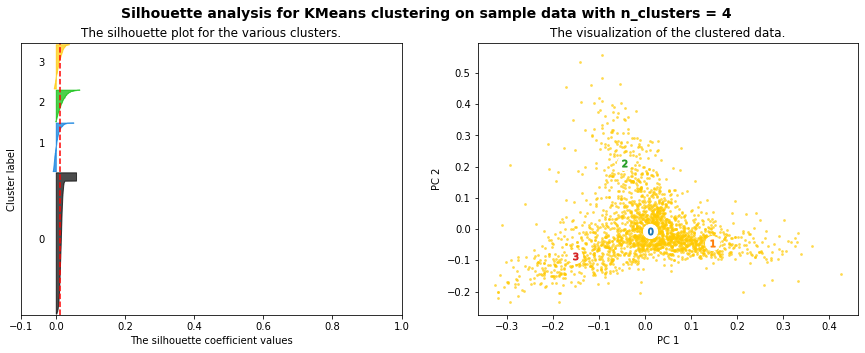

For n_clusters = 4, The average silhouette_score is : 0.012


In [32]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


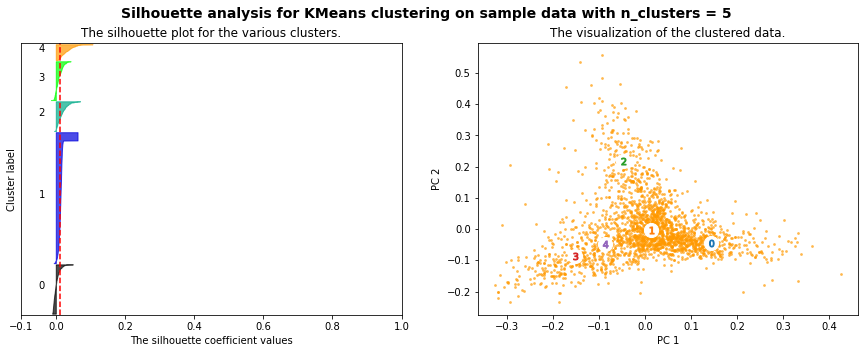

For n_clusters = 5, The average silhouette_score is : 0.013


In [33]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


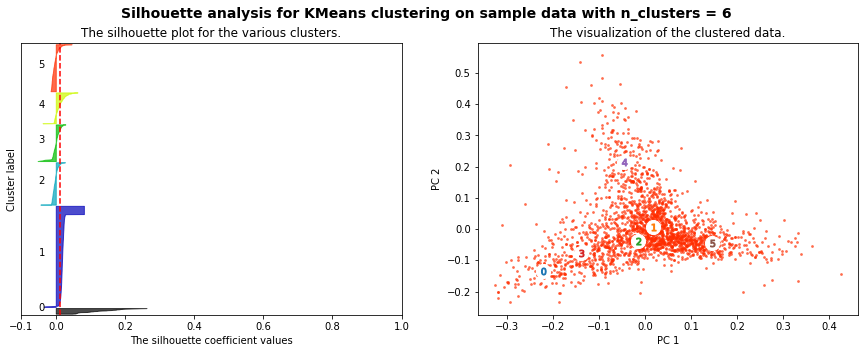

For n_clusters = 6, The average silhouette_score is : 0.011


In [34]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [2]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pd.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

Unnamed: 0                                       download_url  \
0           0  https://raw.githubusercontent.com/lintool/Grim...   
1           1  https://raw.githubusercontent.com/lintool/Grim...   
2           2  https://raw.githubusercontent.com/lintool/Grim...   
3           3  https://raw.githubusercontent.com/lintool/Grim...   
4           4  https://raw.githubusercontent.com/lintool/Grim...   

                                            html_url                    name  \
0  https://github.com/lintool/GrimmerSenatePressR...  01Apr2005Kennedy14.txt   
1  https://github.com/lintool/GrimmerSenatePressR...  01Aug2005Kennedy12.txt   
2  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy10.txt   
3  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy11.txt   
4  https://github.com/lintool/GrimmerSenatePressR...  01Aug2006Kennedy12.txt   

                                 path  \
0  raw/Kennedy/01Apr2005Kennedy14.txt   
1  raw/Kennedy/01Aug2005Kennedy12.txt   
2  raw/Kennedy/01Aug2006Kennedy10.txt   
3  raw/Kennedy/01Aug2006Kennedy11.txt   
4  raw/Kennedy/01Aug2006Kennedy12.txt   

                                                text targetSenator  
0           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
1           FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy  
2           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy  
3           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy  
4           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [3]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [4]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

'Missing "Senate"'

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [31]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [32]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [40]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

KMeans(n_clusters=3)

And visualize:

In [41]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

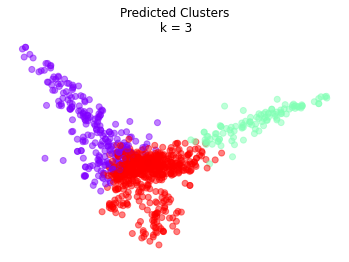

In [42]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [43]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

Unnamed: 0                                       download_url  \
0             0  https://raw.githubusercontent.com/lintool/Grim...   
1             1  https://raw.githubusercontent.com/lintool/Grim...   
2             2  https://raw.githubusercontent.com/lintool/Grim...   
3             3  https://raw.githubusercontent.com/lintool/Grim...   
4             4  https://raw.githubusercontent.com/lintool/Grim...   
..          ...                                                ...   
994         995  https://raw.githubusercontent.com/lintool/Grim...   
995         996  https://raw.githubusercontent.com/lintool/Grim...   
996         997  https://raw.githubusercontent.com/lintool/Grim...   
997         998  https://raw.githubusercontent.com/lintool/Grim...   
998         999  https://raw.githubusercontent.com/lintool/Grim...   

                                              html_url  \
0    https://github.com/lintool/GrimmerSenatePressR...   
1    https://github.com/lintool/GrimmerSenatePressR...   
2    https://github.com/lintool/GrimmerSenatePressR...   
3    https://github.com/lintool/GrimmerSenatePressR...   
4    https://github.com/lintool/GrimmerSenatePressR...   
..                                                 ...   
994  https://github.com/lintool/GrimmerSenatePressR...   
995  https://github.com/lintool/GrimmerSenatePressR...   
996  https://github.com/lintool/GrimmerSenatePressR...   
997  https://github.com/lintool/GrimmerSenatePressR...   
998  https://github.com/lintool/GrimmerSenatePressR...   

                       name                                path  \
0    01Apr2005Kennedy14.txt  raw/Kennedy/01Apr2005Kennedy14.txt   
1    01Aug2005Kennedy12.txt  raw/Kennedy/01Aug2005Kennedy12.txt   
2    01Aug2006Kennedy10.txt  raw/Kennedy/01Aug2006Kennedy10.txt   
3    01Aug2006Kennedy11.txt  raw/Kennedy/01Aug2006Kennedy11.txt   
4    01Aug2006Kennedy12.txt  raw/Kennedy/01Aug2006Kennedy12.txt   
..                      ...                                 ...   
994  18Jul2005Kennedy13.txt  raw/Kennedy/18Jul2005Kennedy13.txt   
995  18Jul2005Kennedy14.txt  raw/Kennedy/18Jul2005Kennedy14.txt   
996   18Jul2006Kennedy0.txt   raw/Kennedy/18Jul2006Kennedy0.txt   
997   18Jul2006Kennedy1.txt   raw/Kennedy/18Jul2006Kennedy1.txt   
998   18Jul2006Kennedy2.txt   raw/Kennedy/18Jul2006Kennedy2.txt   

                                                  text targetSenator  \
0             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
1             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
2             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
3             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
4             FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
..                                                 ...           ...   
994           FOR IMMEDIATE RELEASE     Department ...       Kennedy   
995           FOR IMMEDIATE RELEASE     I welcome t...       Kennedy   
996           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
997           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
998           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   

     kmeans_predictions  
0                     0  
1                     2  
2                     0  
3                     2  
4                     2  
..                  ...  
994                   0  
995                   2  
996                   2  
997                   2  
998                   2  

[999 rows x 8 columns]

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In [6]:
def clean_raw_text(raw_texts):
    """
    Clean text documents during pre-processing.
    :param raw_texts: list of raw texts to pre process.
    """

    common_stopwords = ["THE PRESIDENT:", "(Applause.)", "(applause)", "(Laughter.)"]
    stopwords = [x.lower() for x in common_stopwords]
    
    clean_texts = []
    for text in raw_texts:
        try:
            clean_text = text.replace(" \'m", 
                                    "'m").replace(" \'ll", 
                                    "'ll").replace(" \'re", 
                                    "'re").replace(" \'s",
                                    "'s").replace(" \'re", 
                                    "'re").replace(" n\'t", 
                                    "n't").replace(" \'ve", 
                                    "'ve").replace(" /'d", 
                                    "'d").replace('\n','')
            
            clean_text = clean_text.rstrip(" ").rstrip(" ' ").replace("\xa0", "")
            querywords = clean_text.split()
            resultwords  = [word for word in querywords if word.lower() not in stopwords]
            final_text = ' '.join(resultwords)

            clean_texts.append(final_text)
        except AttributeError:
            print("ERROR CLEANING")
            # print(text)
            continue
    return clean_texts

def vectorize_documents(dataframe, column, vector_type="tfidf"):
    """
    Wrapper function to vectorize documents.
    """
    if  vector_type == "tfidf":
        vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
    elif vector_type == "count":
        vectorizer = sklearn.feature_extraction.text.CountVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
    else:
        print("Incorrect vector_type input")
        return

    vectorized = vectorizer.fit_transform(dataframe[column])

    return vectorized


In [7]:
def plotSilhouette_refined(n_clusters, num_p_components, vectorized_text):
    """
    A refined version of the plotSilhoette function. Uses dimensionality reduction
    to reduce data in function's body.

    :param n_clusters: int,  k number of clusters
    :num_p_components: int,  number of principal components for PCA
    :vectorized_text: sparse matrix, vectorized form of documents
    """

    X = vectorized_text.toarray()
    PCA = sklearn.decomposition.PCA
    pca = PCA(n_components = num_p_components).fit(vectorized_text.toarray())
    reduced_data = pca.transform(vectorized_text.toarray())

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    print(f"Average silhouette score for {n_clusters} clusters is {silhouette_avg}")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

In [8]:
speeches = pd.read_excel(r"../data/speeches_labeled.xlsx")
speeches = speeches.drop(columns="Unnamed: 0")
speeches["Speech"] = speeches.Speech.apply(lambda row: clean_raw_text([row])[0])
speeches['tokenized_text'] = speeches['Speech'].apply(lambda x: lucem_illud.word_tokenize(x))
speeches['normalized_text'] = speeches['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))
speeches.head()

President              Date  \
0     Joe Biden  January 20, 2021   
1  Donald Trump  January 19, 2021   
2  Donald Trump  January 13, 2021   
3  Donald Trump  January 07, 2021   
4  Donald Trump  January 06, 2021   

                                              Speech           climate_stance  \
0  Chief Justice Roberts, Vice President Harris, ...   pro-climate-regulation   
1  My fellow Americans: Four years ago, we launch...  anti-climate-regulation   
2  My fellow Americans,I want to speak to you ton...                  neutral   
3  I would like to begin by addressing the heinou...                  neutral   
4  I know your pain. I know your hurt.We had an e...                  neutral   

                                      tokenized_text  \
0  [Chief, Justice, Roberts, Vice, President, Har...   
1  [My, fellow, Americans, Four, years, ago, we, ...   
2  [My, fellow, Americans, I, want, to, speak, to...   
3  [I, would, like, to, begin, by, addressing, th...   
4  [I, know, your, pain, I, know, your, hurt, We,...   

                                     normalized_text  
0  [chief, justice, roberts, vice, president, har...  
1  [fellow, americans, year, ago, launch, great, ...  
2  [fellow, americans, want, speak, tonight, trou...  
3  [like, begin, address, heinous, attack, unite,...  
4  [know, pain, know, hurt, election, steal, land...

In [10]:
speeches.President.unique()

array(['Joe Biden', 'Donald Trump', 'Barack Obama', 'George W. Bush',
       'Bill Clinton', 'George H. W. Bush'], dtype=object)

In [9]:
speeches_tfidf_vect = vectorize_documents (speeches, "Speech", "tfidf")
X_speeches = speeches_tfidf_vect.toarray()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
Average silhouette score for 2 clusters is 0.019463641762626372


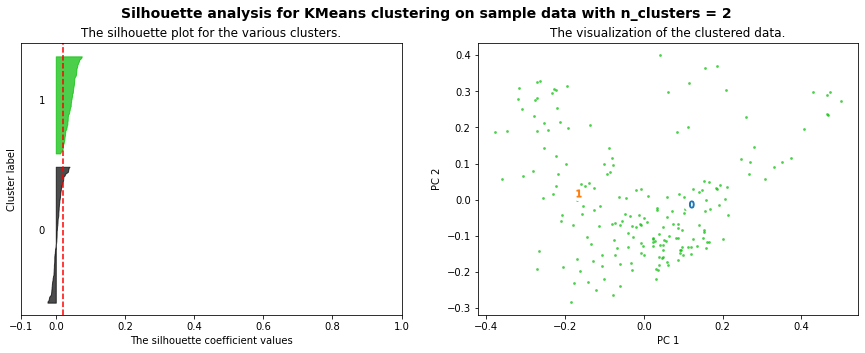

For n_clusters = 2, The average silhouette_score is : 0.019
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
Average silhouette score for 4 clusters is 0.01919186056499059


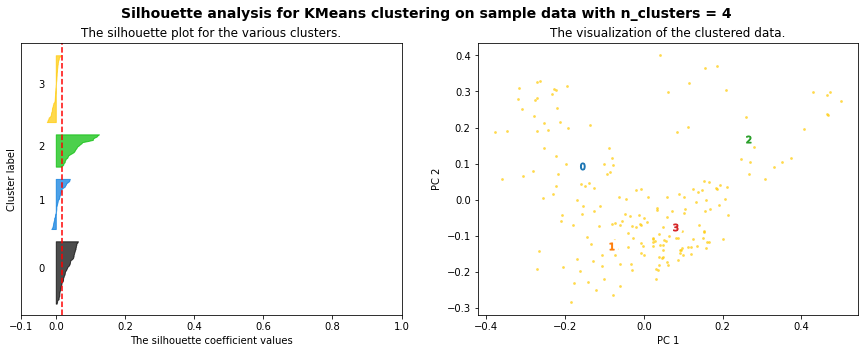

For n_clusters = 4, The average silhouette_score is : 0.019
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
Average silhouette score for 6 clusters is 0.019903096569125707


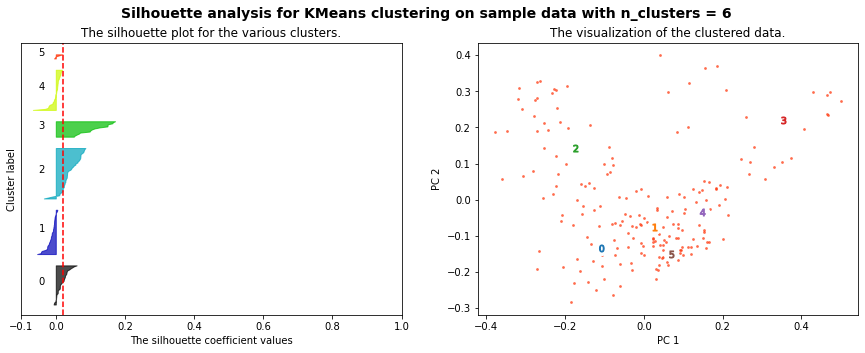

For n_clusters = 6, The average silhouette_score is : 0.020
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
Average silhouette score for 8 clusters is 0.025608384843242824


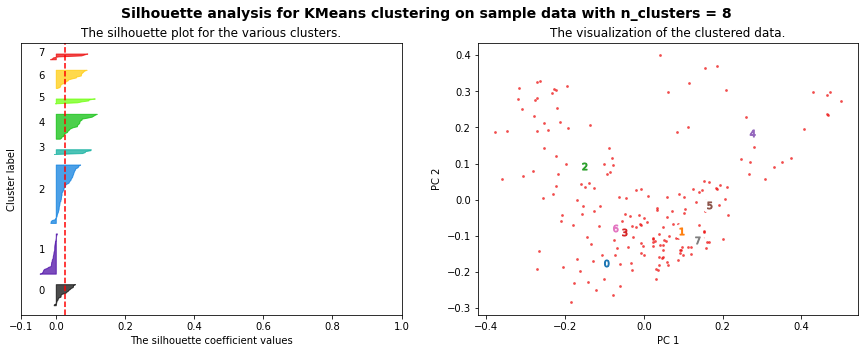

For n_clusters = 8, The average silhouette_score is : 0.026
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
Average silhouette score for 10 clusters is 0.016030555995038817


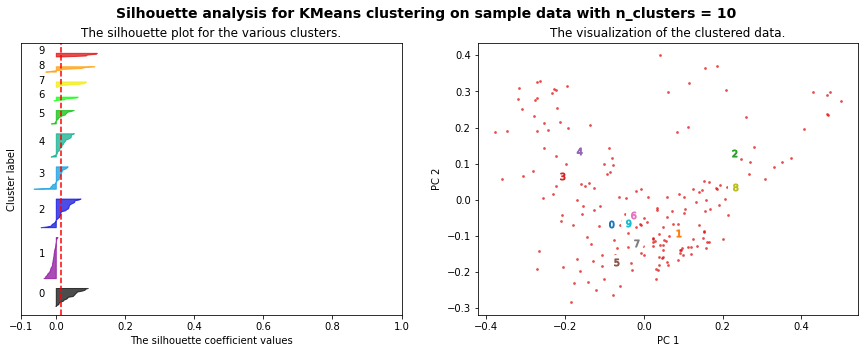

For n_clusters = 10, The average silhouette_score is : 0.016


In [34]:
# Run grid search to optimize silhouette score and find optimal number of clusters k
for k in [2,4,6,8, 10]:
    plotSilhouette_refined(k, 2, speeches_tfidf_vect)

Surprisingly, from the above grid search the optimal number of cluster is k=8. One valid hypothesis would have been that the optimal k would have been either 2 or 6, 2 if party affiliation would be the main differentiator and 6 if personal style of presidents was the best differentiator.

In [ ]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

In [40]:
optimal_speech_kmean = sklearn.cluster.KMeans(n_clusters=8, random_state=10, init='k-means++')
X = speeches_tfidf_vect.toarray()
optimal_speech_kmean.fit_predict(X)

PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(X)
reduced_speeches = pca.transform(X)

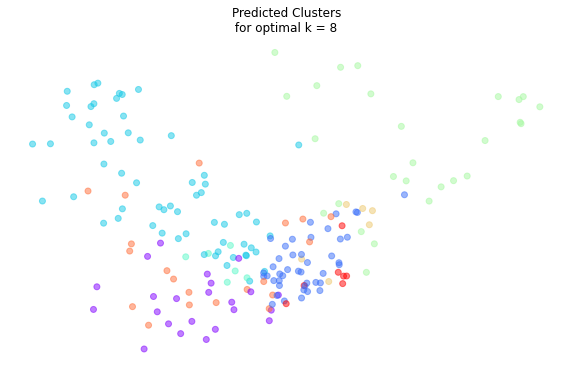

In [45]:
colors = list(plt.cm.rainbow(np.linspace(0,1, 8)))
colors_p = [colors[l] for l in optimal_speech_kmean.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_speeches[:, 0], reduced_speeches[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n for optimal k = 8 ')
plt.show()

In [46]:
# Compare clusters when using the unique number of presidents as k (6)
optimal_speech_kmean = sklearn.cluster.KMeans(n_clusters=6, random_state=10, init='k-means++')
X = speeches_tfidf_vect.toarray()
optimal_speech_kmean.fit_predict(X)

PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(X)
reduced_speeches = pca.transform(X)

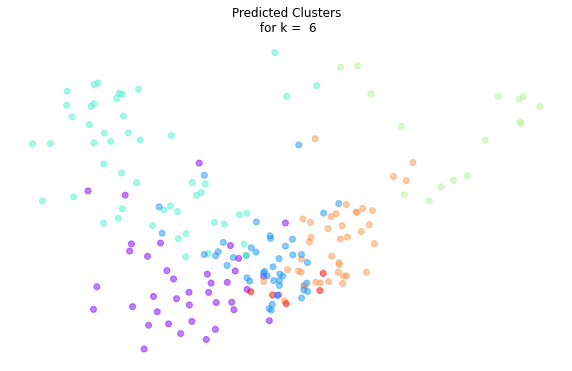

In [57]:
colors = list(plt.cm.rainbow(np.linspace(0,1, 6)))
colors_p = [colors[l] for l in optimal_speech_kmean.labels_]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_speeches[:, 0], reduced_speeches[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n for k =  6')
plt.show()

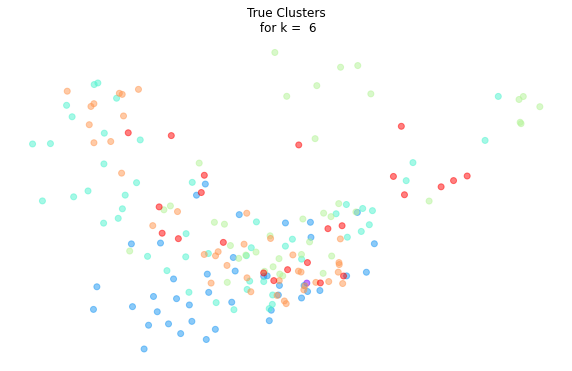

In [60]:
colors = {pres:color for pres, color in zip(speeches.President.unique(), list(plt.cm.rainbow(np.linspace(0,1, 6))))}

colors_p = [colors[pres] for pres in speeches.President.values]

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_speeches[:, 0], reduced_speeches[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('True Clusters\n for k =  6')
plt.show()

As seen in the PCA plots above using the first 2 principal components, using the speaker of speeches as labels 
does not seem to be a good feature to differentiate clusters as the true clusters plot does not seem to show any 
meaningul relationship. There is a lot of overlap among speeches despite the speaker of the speech. Furthermore, 
when we compare the true labels pca plot to the predicted labels using K-means clustering there does not seem to be
significant overlap which indicates that the speakers themselves cannot be differentiated using this approach of k-means.

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [15]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [16]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [17]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [18]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [20]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [21]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

array([[126.        , 193.        ,   0.        ,   2.        ],
       [195.        , 200.        ,   0.        ,   3.        ],
       [198.        , 201.        ,   0.        ,   4.        ],
       [ 55.        , 202.        ,   0.37033177,   5.        ],
       [104.        , 169.        ,   0.40914841,   2.        ],
       [ 60.        ,  94.        ,   0.44134524,   2.        ],
       [ 99.        , 162.        ,   0.45096656,   2.        ],
       [151.        , 204.        ,   0.4553535 ,   3.        ],
       [117.        , 206.        ,   0.4650683 ,   3.        ],
       [ 52.        ,  96.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

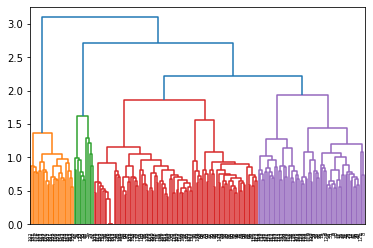

In [22]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

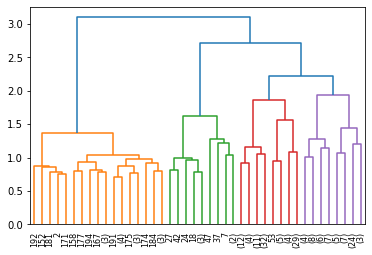

In [59]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=5, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [24]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 2, 4, 4, 4,
       3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2, 3, 2, 4, 4, 2, 4,
       4, 4, 4, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4, 3, 2, 4, 4, 3, 4,
       3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3, 3, 4, 4, 3, 1, 1,
       1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3, 1, 3, 3, 1,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [25]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [26]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

text  \
0     \tIn certain Apple 13" RGB monitors there has ...   
1     Does anyone know how to reach Micron?  I am in...   
2     Hi there!\n\nCould some kind soul tell me what...   
3                                           "auto\nfrom   
4     \n\n    Don't believe the hype. There is no su...   
...                                                 ...   
2345  I was wondering if anyone out in net-land have...   
2346  \n\n\n\n\nI sold my '86 Sprint last April with...   
2347  Actually I wasn't too surprised, since I bough...   
2348  \n\nI couldnt agree more.  That is how it SHOU...   
2349  \nWarren Brown, the Washington Post's auto wri...   

                   category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
...                     ...   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  wald_predictions  
0     ../data/scikit_learn_data/20news_home/20news-b...                 4  
1     ../data/scikit_learn_data/20news_home/20news-b...                 4  
2     ../data/scikit_learn_data/20news_home/20news-b...                 4  
3     ../data/scikit_learn_data/20news_home/20news-b...                 4  
4     ../data/scikit_learn_data/20news_home/20news-b...                 4  
...                                                 ...               ...  
2345  ../data/scikit_learn_data/20news_home/20news-b...                 4  
2346  ../data/scikit_learn_data/20news_home/20news-b...                 2  
2347  ../data/scikit_learn_data/20news_home/20news-b...                 2  
2348  ../data/scikit_learn_data/20news_home/20news-b...                 4  
2349  ../data/scikit_learn_data/20news_home/20news-b...                 4  

[2350 rows x 4 columns]

# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [33]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

And visualize the tree:

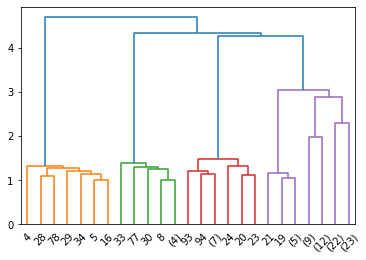

In [61]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [35]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [38]:
# First calculate similarity across documents
speechesCoocMat = speeches_tfidf_vect * speeches_tfidf_vect.T

#set the diagonal to 0 since we don't care how similar texts are to themselves
speechesCoocMat.setdiag(0)

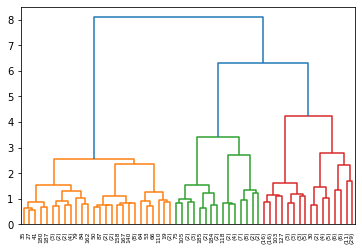

In [101]:
# Hierarchical cluster 1 using Ward
speeches_ward_matrix = scipy.cluster.hierarchy.ward(speechesCoocMat.toarray())
ax = scipy.cluster.hierarchy.dendrogram(speeches_ward_matrix, p=5, truncate_mode='level')

From the above figure ward hierarchical cluster shows k=3 is optimal number of clusters. Ward is an agglomerative hierarchical clustering algorithm, which 
means that it is "bottom up" thus it starts with each document in its own cluster and then pars clusters merging them as it moves through the hierarchy. 
Ward found three total clusters which seem to be inbalanced in that clusters do not seem to be roughly the same size. Furthermore, cluster one seems to have larger total
distance between samples while cluster three (red) appears to have a smaller distance. This reveals that using the presidential speeches corpus, as we saw with k-means
speaker identity does not seem to be the most indicative feature for cluster differentiation.

In [98]:
clusters_speeches = scipy.cluster.hierarchy.fcluster(speeches_ward_matrix, 5, criterion='distance')
sample_silhouette_values = sklearn.metrics.silhouette_samples(speechesCoocMat, clusters_speeches)

In [100]:
clusters_speeches

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3,
       3, 3, 3, 2, 3, 1, 3, 2, 3, 3, 3, 3, 3, 1, 1, 2, 2, 3, 3, 1, 3, 1,
       3, 1, 3, 3, 1, 3, 1, 1, 3, 1, 3, 3, 2, 1, 1, 3, 3, 3, 3, 1, 1, 2,
       1, 2, 2, 2, 3, 1, 3, 1, 2, 2, 3, 3, 3, 1, 1, 1, 2, 2, 1, 2, 3, 1,
       1, 3, 3, 2, 1, 3, 3, 3, 3, 1, 2, 2, 3, 2, 2, 3, 2, 2, 3, 3, 2, 3,
       1, 2, 2, 3, 3, 2, 3, 2, 2, 2, 3, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 3,
       3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3,
       3, 1, 3, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 2, 2, 3, 3, 1,
       1, 3, 2, 2, 1, 2, 3, 2, 2, 2, 3, 1, 3, 3, 1, 3, 3, 3], dtype=int32)

In [48]:
category_dict = {pres:i for i,pres in enumerate(speeches.President.unique())}
speeches["category"] = speeches.President.apply(lambda row: category_dict[row])
speeches.head()

President              Date  \
0     Joe Biden  January 20, 2021   
1  Donald Trump  January 19, 2021   
2  Donald Trump  January 13, 2021   
3  Donald Trump  January 07, 2021   
4  Donald Trump  January 06, 2021   

                                              Speech           climate_stance  \
0  Chief Justice Roberts, Vice President Harris, ...   pro-climate-regulation   
1  My fellow Americans: Four years ago, we launch...  anti-climate-regulation   
2  My fellow Americans,I want to speak to you ton...                  neutral   
3  I would like to begin by addressing the heinou...                  neutral   
4  I know your pain. I know your hurt.We had an e...                  neutral   

                                      tokenized_text  \
0  [Chief, Justice, Roberts, Vice, President, Har...   
1  [My, fellow, Americans, Four, years, ago, we, ...   
2  [My, fellow, Americans, I, want, to, speak, to...   
3  [I, would, like, to, begin, by, addressing, th...   
4  [I, know, your, pain, I, know, your, hurt, We,...   

                                     normalized_text  category  
0  [chief, justice, roberts, vice, president, har...         0  
1  [fellow, americans, year, ago, launch, great, ...         1  
2  [fellow, americans, want, speak, tonight, trou...         1  
3  [like, begin, address, heinous, attack, unite,...         1  
4  [know, pain, know, hurt, election, steal, land...         1

In [99]:
print("Scores for ward hierarchical matrix")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speeches['category'], clusters_speeches)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speeches['category'], clusters_speeches)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speeches['category'], clusters_speeches)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speeches['category'], clusters_speeches)))
print(f"Average silhouette score {sample_silhouette_values.mean()}")

Scores for ward hierarchical matrix
Homogeneity: 0.087
Completeness: 0.144
V-measure: 0.108
Adjusted Rand Score: 0.049
Average silhouette score 0.25563398123026154


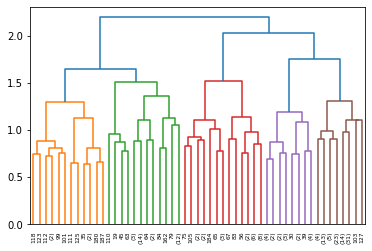

In [102]:
# Hierarchical cluster 2 using complete linkage, see: https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.complete.html#scipy.cluster.hierarchy.complete
speeches_complete_matrix = scipy.cluster.hierarchy.complete(speechesCoocMat.toarray())
ax = scipy.cluster.hierarchy.dendrogram(speeches_complete_matrix, p=5, truncate_mode='level')

In [90]:
# From the above figure complete linkage hierarchical cluster shows k=5 is optimal number of clusters
clusters_speeches = scipy.cluster.hierarchy.fcluster(speeches_complete_matrix, 1.6, criterion='distance')
sample_silhouette_values = sklearn.metrics.silhouette_samples(speechesCoocMat, clusters_speeches)

In [91]:
print("Scores for ward hierarchical matrix")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speeches['category'], clusters_speeches)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speeches['category'], clusters_speeches)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speeches['category'], clusters_speeches)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speeches['category'], clusters_speeches)))
print(f"Average silhouette score {sample_silhouette_values.mean()}")

Scores for ward hierarchical matrix
Homogeneity: 0.166
Completeness: 0.193
V-measure: 0.178
Adjusted Rand Score: 0.065
Average silhouette score 0.18837502746544837


Complete linkage clustering, as Ward, is also a agglomerative clustering method. In this case we find that the optimal number of clusters (obtained
by looking at the dendogram) seems to be 5 clusters. While the complete linkage clustering has a lower silhouette average score than the ward results,
it achieves higher homogeneity, completenes, etc scores since it approximates a closter number of optimal clusters to the unique number of speakers. 

In [107]:
# play with distance to see how it affects the number of clusters generated
print("Using ward clustering")
for dist in [.3, .8, 1.5, 3, 5]:
    clusters_speeches = scipy.cluster.hierarchy.fcluster(speeches_ward_matrix, dist, criterion='distance')
    print(f"With a distance of {dist} we get {len(np.unique(clusters_speeches))} number of clusters")

print()
print("Using complete linkage clustering")
for dist in [.3, .8, 1.5, 3, 5]:
    clusters_speeches = scipy.cluster.hierarchy.fcluster(speeches_complete_matrix, dist, criterion='distance')
    print(f"With a distance of {dist} we get {len(np.unique(clusters_speeches))} number of clusters")


Using ward clustering
With a distance of 0.3 we get 191 number of clusters
With a distance of 0.8 we get 60 number of clusters
With a distance of 1.5 we get 14 number of clusters
With a distance of 3 we get 5 number of clusters
With a distance of 5 we get 3 number of clusters

Using complete linkage clustering
With a distance of 0.3 we get 191 number of clusters
With a distance of 0.8 we get 52 number of clusters
With a distance of 1.5 we get 7 number of clusters
With a distance of 3 we get 1 number of clusters
With a distance of 5 we get 1 number of clusters


As seen above for both ward clustering as well as linkage clustering the distance used when forming flat clusters 
has an inverse relationship with the number of clusters created, that is as distance increases number of clusters decreases.

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [10]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x))

In [11]:
senReleasesTraining[::100]

Unnamed: 0                                       download_url  \
0             0  https://raw.githubusercontent.com/lintool/Grim...   
100         101  https://raw.githubusercontent.com/lintool/Grim...   
200         201  https://raw.githubusercontent.com/lintool/Grim...   
300         301  https://raw.githubusercontent.com/lintool/Grim...   
400         401  https://raw.githubusercontent.com/lintool/Grim...   
500         501  https://raw.githubusercontent.com/lintool/Grim...   
600         601  https://raw.githubusercontent.com/lintool/Grim...   
700         701  https://raw.githubusercontent.com/lintool/Grim...   
800         801  https://raw.githubusercontent.com/lintool/Grim...   
900         901  https://raw.githubusercontent.com/lintool/Grim...   

                                              html_url  \
0    https://github.com/lintool/GrimmerSenatePressR...   
100  https://github.com/lintool/GrimmerSenatePressR...   
200  https://github.com/lintool/GrimmerSenatePressR...   
300  https://github.com/lintool/GrimmerSenatePressR...   
400  https://github.com/lintool/GrimmerSenatePressR...   
500  https://github.com/lintool/GrimmerSenatePressR...   
600  https://github.com/lintool/GrimmerSenatePressR...   
700  https://github.com/lintool/GrimmerSenatePressR...   
800  https://github.com/lintool/GrimmerSenatePressR...   
900  https://github.com/lintool/GrimmerSenatePressR...   

                       name                                path  \
0    01Apr2005Kennedy14.txt  raw/Kennedy/01Apr2005Kennedy14.txt   
100   02Feb2006Kennedy8.txt   raw/Kennedy/02Feb2006Kennedy8.txt   
200   04May2006Kennedy7.txt   raw/Kennedy/04May2006Kennedy7.txt   
300   06Jun2006Kennedy5.txt   raw/Kennedy/06Jun2006Kennedy5.txt   
400   08Dec2006Kennedy4.txt   raw/Kennedy/08Dec2006Kennedy4.txt   
500  09Nov2005Kennedy10.txt  raw/Kennedy/09Nov2005Kennedy10.txt   
600   11Nov2005Kennedy5.txt   raw/Kennedy/11Nov2005Kennedy5.txt   
700   13Jun2006Kennedy0.txt   raw/Kennedy/13Jun2006Kennedy0.txt   
800   15Dec2005Kennedy4.txt   raw/Kennedy/15Dec2005Kennedy4.txt   
900  16May2007Kennedy10.txt  raw/Kennedy/16May2007Kennedy10.txt   

                                                  text targetSenator  \
0             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
100           FOR IMMEDIATE RELEASE  Washington  DC...       Kennedy   
200           FOR IMMEDIATE RELEASE      FOR IMMEDI...       Kennedy   
300           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
400           FOR IMMEDIATE RELEASE  Washington  D ...       Kennedy   
500           FOR IMMEDIATE RELEASE     Washington ...       Kennedy   
600           FOR IMMEDIATE RELEASE     On this Vet...       Kennedy   
700           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
800           FOR IMMEDIATE RELEASE     Washington ...       Kennedy   
900           FOR IMMEDIATE RELEASE  WASHINGTON  D ...       Kennedy   

                                        tokenized_text  \
0    [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
100  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
200  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
300  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
400  [FOR, IMMEDIATE, RELEASE, Washington, D, C, To...   
500  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
600  [FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...   
700  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
800  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
900  [FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...   

                                     normalized_tokens  
0    [immediate, release, immediate, release, conta...  
100  [immediate, release, washington, dc, today, se...  
200  [immediate, release, immediate, release, washi...  
300  [immediate, release, immediate, release, surpr...  
400  [immediate, release, washington, have, c, toda...  
500  [immediate, release, washington, dc, today, se...  
600  [immediate, release, 

In [110]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [111]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [112]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [113]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [114]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [115]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(9, 0.9734879)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [117]:
ldaDF = pd.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [119]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

name  \
1    01Aug2005Kennedy12.txt   
101  02Feb2007Kennedy10.txt   
201   04May2006Kennedy8.txt   
301   06Jun2007Kennedy1.txt   
401   08Feb2005Kennedy0.txt   
501  09Nov2005Kennedy11.txt   
601   11Nov2005Kennedy6.txt   
701   13Jun2006Kennedy1.txt   
801   15Dec2005Kennedy5.txt   
901   16May2007Kennedy5.txt   

                                                topics   topic_0  topic_1  \
1                                    [(6, 0.97169524)]  0.000000  0.00000   
101                                   [(0, 0.9949952)]  0.994995  0.00000   
201                                   [(7, 0.9976059)]  0.000000  0.00000   
301                [(1, 0.010379692), (9, 0.98177874)]  0.000000  0.01038   
401  [(2, 0.26143152), (7, 0.497095), (8, 0.23629828)]  0.000000  0.00000   
501                 [(5, 0.50104886), (6, 0.45988017)]  0.000000  0.00000   
601                                   [(0, 0.9721478)]  0.972148  0.00000   
701                   [(0, 0.721468), (8, 0.27229685)]  0.721468  0.00000   
801  [(0, 0.02630758), (2, 0.75072247), (5, 0.02385...  0.026308  0.00000   
901                  [(0, 0.6274859), (6, 0.33173978)]  0.627486  0.00000   

      topic_2  topic_3  topic_4   topic_5   topic_6   topic_7   topic_8  \
1    0.000000      0.0      0.0  0.000000  0.971695  0.000000  0.000000   
101  0.000000      0.0      0.0  0.000000  0.000000  0.000000  0.000000   
201  0.000000      0.0      0.0  0.000000  0.000000  0.997606  0.000000   
301  0.000000      0.0      0.0  0.000000  0.000000  0.000000  0.000000   
401  0.261432      0.0      0.0  0.000000  0.000000  0.497095  0.236298   
501  0.000000      0.0      0.0  0.501049  0.459880  0.000000  0.000000   
601  0.000000      0.0      0.0  0.000000  0.000000  0.000000  0.000000   
701  0.000000      0.0      0.0  0.000000  0.000000  0.000000  0.272297   
801  0.750722      0.0      0.0  0.023853  0.190439  0.000000  0.000000   
901  0.000000      0.0      0.0  0.000000  0.331740  0.000000  0.000000   

      topic_9  
1    0.000000  
101  0.000000  
201  0.000000  
301  0.981779  
401  0.000000  
501  0.000000  
601  0.000000  
701  0.000000  
801  0.000000  
901  0.000000

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [127]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.values
ldaDFVisNames = ldaDFVisN.values
ldaDFV

topic_0   topic_1  topic_2  topic_3  topic_4  topic_5   topic_6   topic_7  \
0  0.000000  0.000000      0.0      0.0      0.0      0.0  0.000000  0.000000   
1  0.000000  0.000000      0.0      0.0      0.0      0.0  0.971695  0.000000   
2  0.000000  0.000000      0.0      0.0      0.0      0.0  0.444072  0.000000   
3  0.000000  0.306624      0.0      0.0      0.0      0.0  0.000000  0.688078   
4  0.000000  0.997706      0.0      0.0      0.0      0.0  0.000000  0.000000   
5  0.000000  0.991461      0.0      0.0      0.0      0.0  0.000000  0.000000   
6  0.000000  0.000000      0.0      0.0      0.0      0.0  0.000000  0.446310   
7  0.967264  0.000000      0.0      0.0      0.0      0.0  0.000000  0.000000   
8  0.000000  0.000000      0.0      0.0      0.0      0.0  0.992720  0.000000   
9  0.000000  0.000000      0.0      0.0      0.0      0.0  0.967589  0.000000   

    topic_8   topic_9  
0  0.000000  0.973487  
1  0.000000  0.000000  
2  0.000000  0.549770  
3  0.000000  0.000000  
4  0.000000  0.000000  
5  0.000000  0.000000  
6  0.544092  0.000000  
7  0.000000  0.000000  
8  0.000000  0.000000  
9  0.000000  0.000000

First we can visualize as a stacked bar chart:

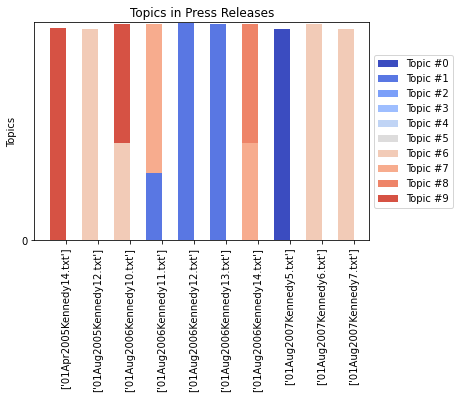

In [128]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

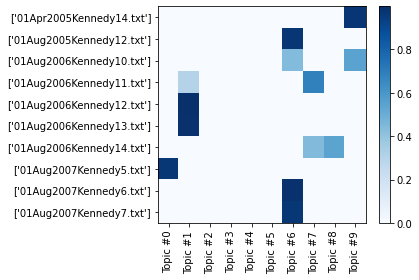

In [129]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [130]:
senlda.show_topic(1)

[('worker', 0.01910421),
 ('wage', 0.012013783),
 ('minimum', 0.009559294),
 ('pension', 0.0068984157),
 ('fund', 0.0060793436),
 ('company', 0.0045019872),
 ('employee', 0.0040087597),
 ('employer', 0.0037514223),
 ('woman', 0.0035879614),
 ('hour', 0.0033116052)]

And if we want to make a dataFrame:

In [131]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pd.DataFrame(topicsDict)
wordRanksDF

Topic_0   Topic_1  Topic_2       Topic_3     Topic_4   Topic_5  \
0        fund    worker     fund          fund        fund      fund   
1       troop      wage  teacher      asbestos        wage     troop   
2     patient   minimum    train        victim        head    worker   
3   insurance   pension    unite         trust      worker      wage   
4    violence      fund     wage  intelligence  bankruptcy     woman   
5    standard   company  minimum        worker     minimum     unite   
6  bankruptcy  employee   worker           fda        loan   pension   
7       train  employer     fail      question    medicare  asbestos   
8      worker     woman     head       concern   insurance    liheap   
9       iraqi      hour     hear         unite      agency      heat   

     Topic_6  Topic_7      Topic_8      Topic_9  
0       loan     head       worker    immigrant  
1       fund   worker       mental         loan  
2     worker     fund         fund       lender  
3       rate     cell  immigration  immigration  
4     lender   agency        unite       worker  
5        aid     stem       victim         fund  
6    company    judge      company        unite  
7  insurance   victim      ireland        troop  
8      unite    unite     northern      company  
9       hear  concern         head    insurance

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

<Figure size 432x288 with 0 Axes>

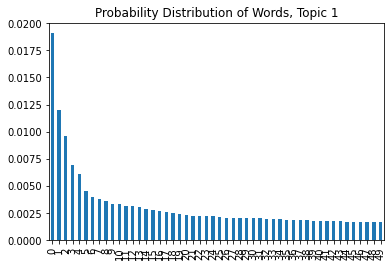

In [132]:
topic1_df = pd.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [133]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

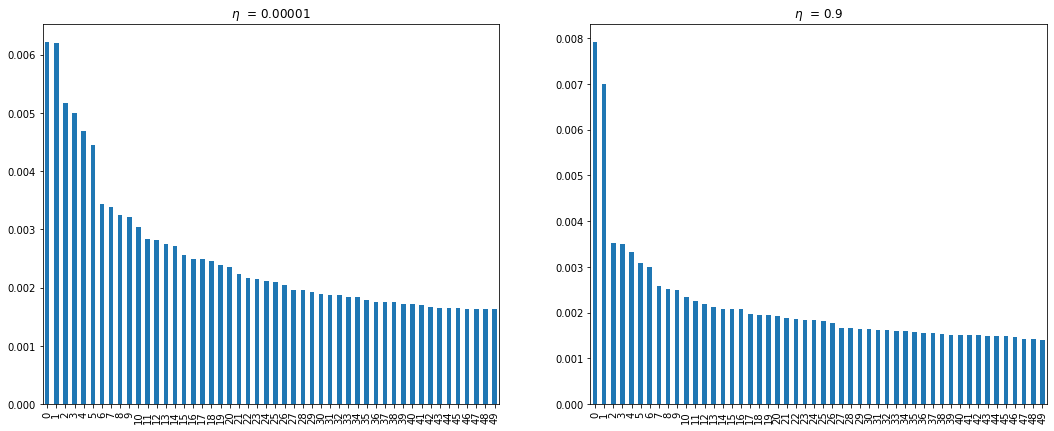

In [135]:
topic11_df = pd.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pd.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

I have previously developed a class for topic modeling and cleaning which I will use here (no need to re-invent the wheel). Please se the TopicModeling.py and PrepareText.py file to see the my implementations.

In [17]:
speeches_docs = [text for text in speeches.Speech.values]

In [68]:
from TopicModeling import TopicModels as LDA_barrosoluquer
from PrepareText import PrepareText
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Clean documents and prepare for LDA
clean_speeches = PrepareText(speeches_docs)

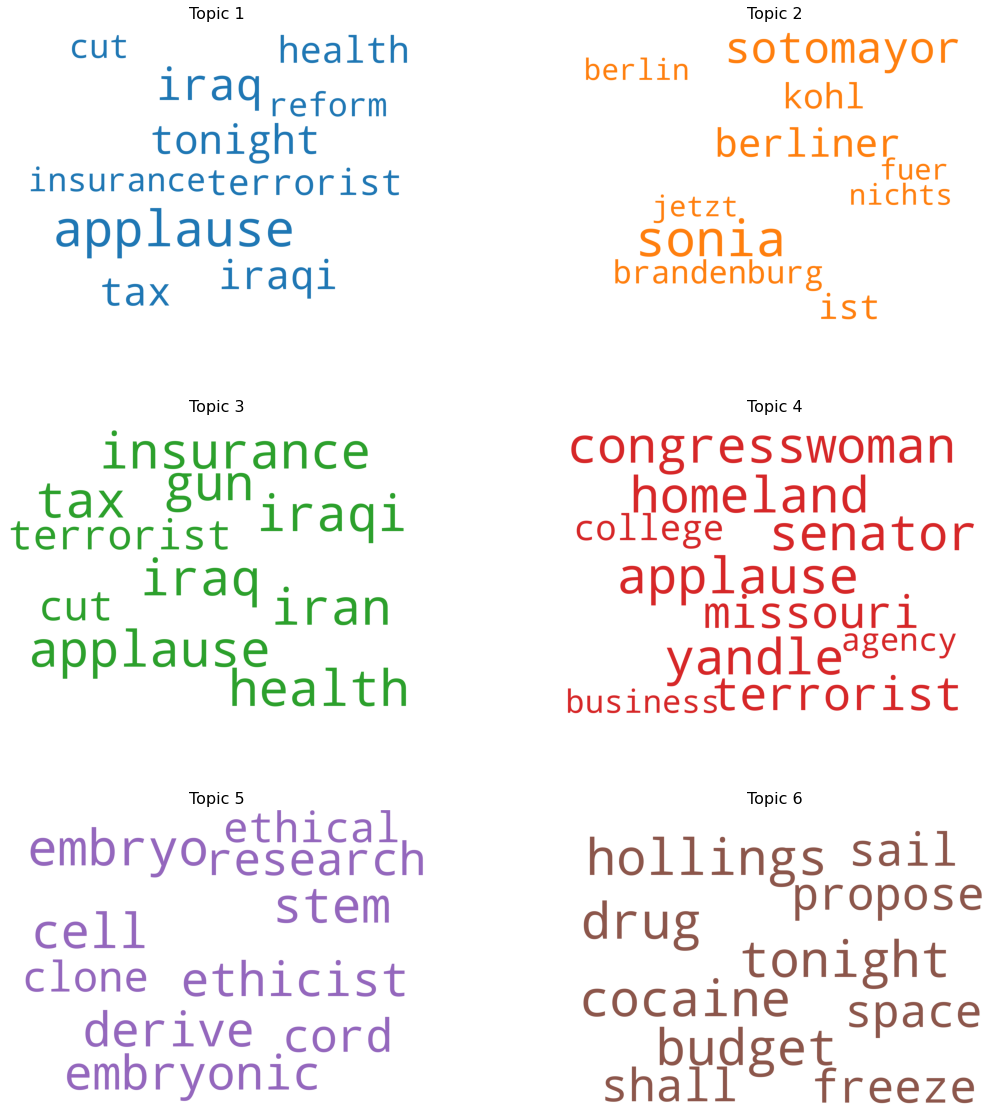

In [43]:
# Use TopicModels class to apply LDA use k = 6 initially
lda_speeches = LDA_barrosoluquer(clean_speeches)
lda_speeches_6 = lda_sppeches.applyLDA(numtopics=6)
lda_speeches.generate_topic_wordcloud(lda_speeches_6)

Above we can see a wordcloud for the 6 generated topics. It seems that while some topics are obviously separate,
for example topic 1 seems to be about foreign wars and topic 5 seems to be about genetic research, there is 
definetly overlap around topics topic 1 and topic 3 for example seem to share some top words. Below we use gridsearch to
optimize for coherence score varying alpha, eta and k.

In [47]:
# Run grid serach by varying hyperparams
params_grid = {
     'alpha_range':[.2,.4,.6,.8, 1],
     'beta_range':[.2,.4,.6,.8, 1],
     'num_topics_range': [2,6,10,15,20]}
results_df = lda_speeches.grid_search(params_grid)
results_df

Models       alpha       beta  \
72   LdaModel(num_terms=11944, num_topics=10, decay...         0.6        0.6   
137  LdaModel(num_terms=11944, num_topics=10, decay...           1        0.8   
157  LdaModel(num_terms=11944, num_topics=10, decay...  asymmetric        0.4   
168  LdaModel(num_terms=11944, num_topics=15, decay...  asymmetric        0.8   
13   LdaModel(num_terms=11944, num_topics=15, decay...         0.2        0.6   
..                                                 ...         ...        ...   
144  LdaModel(num_terms=11944, num_topics=20, decay...           1          1   
15   LdaModel(num_terms=11944, num_topics=2, decay=...         0.2        0.8   
25   LdaModel(num_terms=11944, num_topics=2, decay=...         0.2  symmetric   
50   LdaModel(num_terms=11944, num_topics=2, decay=...         0.4          1   
60   LdaModel(num_terms=11944, num_topics=2, decay=...         0.6        0.2   

     num_topics  coherence_score  
72           10         0.432312  
137          10         0.377574  
157          10         0.377051  
168          15         0.375680  
13           15         0.371144  
..          ...              ...  
144          20         0.265989  
15            2         0.265758  
25            2         0.259856  
50            2         0.256250  
60            2         0.253803  

[180 rows x 5 columns]

In [48]:
results_df.head(1)

Models alpha beta  num_topics  \
72  LdaModel(num_terms=11944, num_topics=10, decay...   0.6  0.6          10   

    coherence_score  
72         0.432312

From the above grid search we find the parameters that optimize coherence score are alpha=.6, beta=.6 and k = 10. Furthermore, it is clear
from the results dataframe that the most important parameter for the speeches corpus seems to be the number of topics chosen.
We can use the LDAmodel saved in the results dataframe to understand the topics of the optimal model by exploring the word distributions.

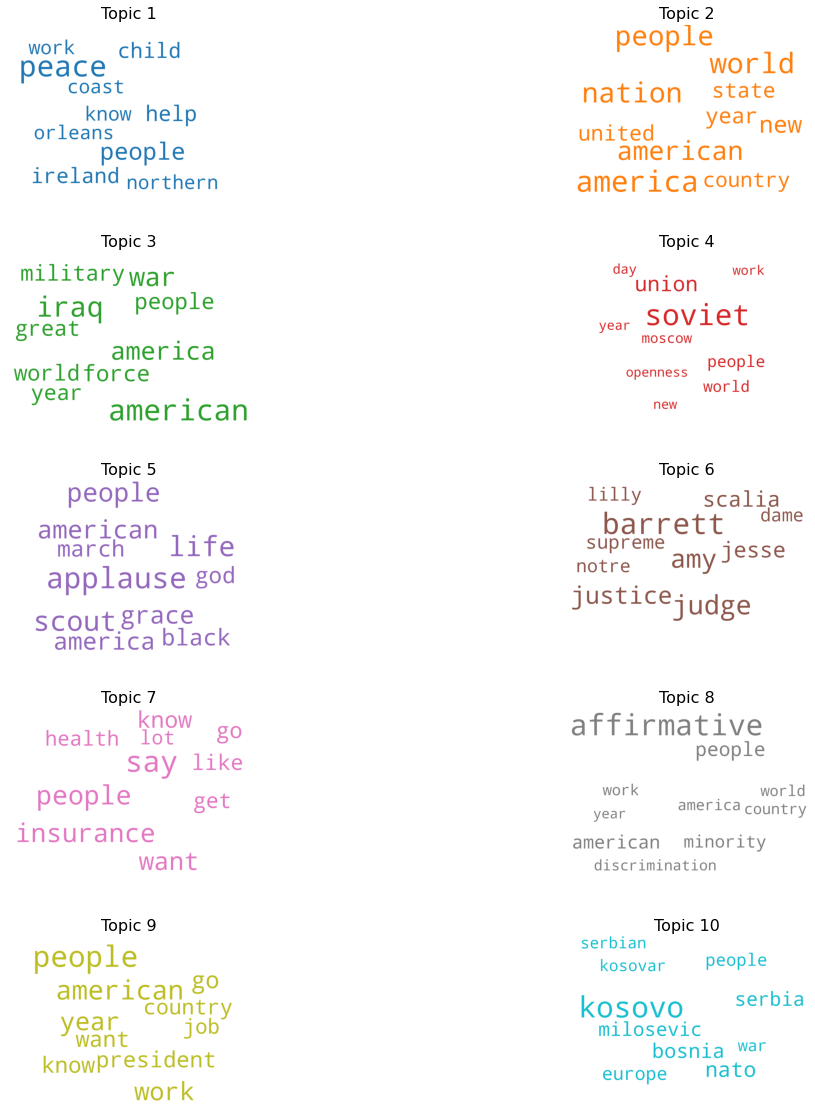

In [51]:
lda_speeches.generate_topic_wordcloud(ldamodel=results_df.iloc[0,0])

Just judging on the distributions of our optimal model from grid search and the first "naive" model we implemented
we see drastic improvements. The optimal model shows 10 distinc clusters with coherent topics my subjective labels for the 
above topics would be as follows:

Topic 1: Welfare and aid.

Topic 2: America and the world.

Topic 3: Foreign wars.

Topic 4: Great power rivalry.

Topic 5: Celebrations.

Topic 6: Supreme Court.

Topic 7: Health insurance.

Topic 8: Diversity/inclusion.

Topic 9: The people's president.

Topic 10: Nato and proxy wars.

We can now check what topic each president talk the most about in their speeches first speech.

In [67]:
topics_speeches = results_df.iloc[0,0].get_document_topics(bow=lda_speeches.corpus)
for president in speeches.President.unique():
    first_speech_idx = speeches.loc[speeches.President == president].first_valid_index()
    print(f"President {president} spoke about {topics_speeches[first_speech_idx]} in his first speech")
    print()

President Joe Biden spoke about [(1, 0.8892383), (8, 0.10393919)] in his first speech

President Donald Trump spoke about [(1, 0.5088657), (8, 0.4859044)] in his first speech

President Barack Obama spoke about [(1, 0.076187685), (8, 0.92046213)] in his first speech

President George W. Bush spoke about [(1, 0.98659223)] in his first speech

President Bill Clinton spoke about [(1, 0.70544654), (8, 0.2830358)] in his first speech

President George H. W. Bush spoke about [(1, 0.9609591), (8, 0.034570873)] in his first speech



This is very interesting, it seems that all presidents mainly spoke about topic 1 and topic 8 in their first speech, the main difference
is which of these two topics they spoke about more. For example it seems Joe Biden mainly talked the "Welfare and Aid" topic while president Obama
mostly spoke about the Diversity and inclusion topic. In general, however, both of these topics are about positively valenced subjects, which makes
sense since presumably the first speech of each president is the inaugural address.

Below we can check the distribution of topics for each 

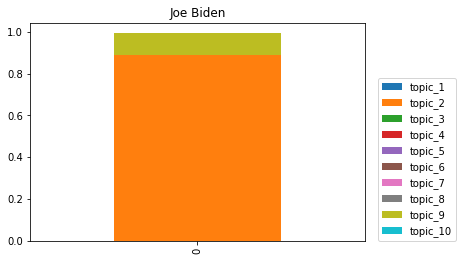

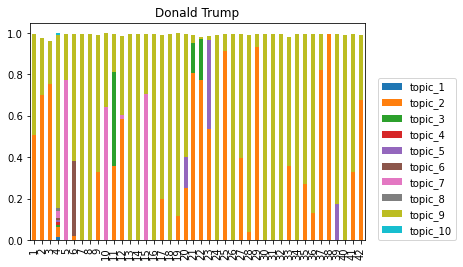

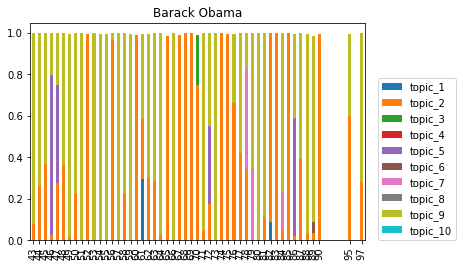

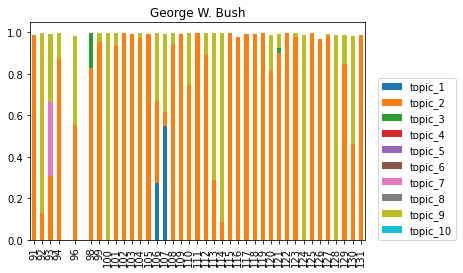

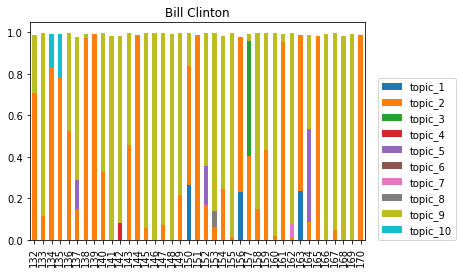

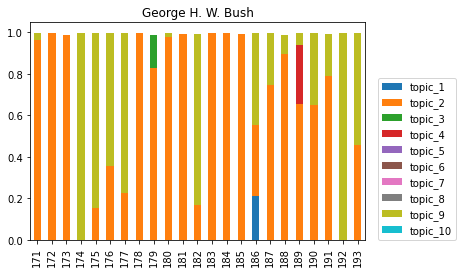

In [111]:
for president in speeches.President.unique():
    speech_idx = speeches.loc[speeches.President == president].index.tolist()
    speech_idx.reverse()
    lda_speeches.generate_bar_plot(ldamodel=results_df.iloc[0,0], docs_to_view=speech_idx, title=president)

It seems that topic 2 and topic 9 are by far the most spoken about topics across speeches of presidents.
However, some interesting patters have emerged, Obama seems to speak a lot about topic 5 (celebrations) and topic 7 (health insurance). 
This is actually incredible, LDA seems to have captured, correctly, that one of Obama's signature legislations was around health insurance 
, aka the Affordable Care Act. Furthemore, George W Bush seems to have given a speech largely about great power rivalry towards the end
of his presidency.

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [86]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [ ]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][9]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor, actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [88]:
corpora_address = r"C:\Users\robal\OneDrive\Escritorio\COHA"

In [89]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

text_1810s_kso.zip
text_1820s_jsi.zip
text_1830s_bsu.zip
text_1840s_nsq.zip
text_1850s_jpr.zip
text_1860s_psi.zip
text_1870s_vuy.zip
text_1880s_azz.zip
text_1890s_jsq.zip
text_1900s_mse.zip
text_1910s_jue.zip
text_1920s_gte.zip
text_1930s_bie.zip
text_1940s_bsw.zip
text_1950s_ndz.zip
text_1960s_xus.zip
text_1970s_jfy.zip
text_1980s_bkk.zip
text_1990s_bsj.zip
text_2000s_scc.zip


In [90]:
list(coha_texts.keys())[0:5]

['mag_1815_552651.txt',
 'mag_1816_552727.txt',
 'mag_1816_552728.txt',
 'mag_1816_552807.txt',
 'mag_1816_552808.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [91]:
coha_genres = {}
coha_years = {}

In [92]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [93]:
coha_genres.keys()

dict_keys(['mag', 'nf', 'fic', 'news'])

In [94]:
coha_years.keys()

dict_keys(['1815', '1816', '1817', '1818', '1819', '1810', '1811', '1812', '1813', '1814', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1839', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [100]:
import collections

In [101]:
years = []
year_lens = []

In [102]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [103]:
years[0], years[-1]

('1810', '2009')

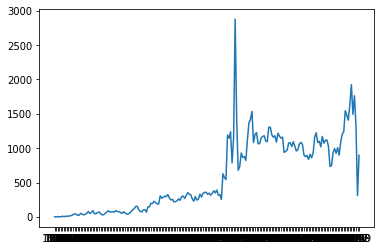

In [104]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [105]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_timeslice[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_timeslice[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_timeslice[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_timeslice[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_timeslice[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [ ]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [ ]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [ ]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [ ]:
final_corpus= []

In [ ]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [ ]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [ ]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [109]:
from gensim.models import ldaseqmodel

In [ ]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)[1]

In [ ]:
 ldaseq.print_topics(time=4)[1]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [ ]:
ldaseq.save("ldaseqmodel")

In [ ]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [117]:
speeches.groupby(by="President")["Speech"].count()

President
Barack Obama         50
Bill Clinton         39
Donald Trump         42
George H. W. Bush    23
George W. Bush       39
Joe Biden             1
Name: Speech, dtype: int64

Below we investigate how George H. W. Bush speeches evolved during his time in office.

In [140]:
from collections import OrderedDict 
from gensim.models import ldaseqmodel

In [139]:
years = [int(date[-4:]) for date in speeches.loc[speeches.President == "George H. W. Bush", "Date"].values]
OrderedDict(sorted({i:years.count(i) for i in years}.items()))

OrderedDict([(1988, 2), (1989, 4), (1990, 6), (1991, 5), (1992, 5), (1993, 1)])

In [126]:
george_hw_bush = [speech for speech in speeches.loc[speeches.President == "George H. W. Bush", "Speech"].values]
# reverse to get in proper chronological order
george_hw_bush.reverse()
hw_bush_prepared_text = PrepareText(george_hw_bush) 

In [141]:
time_slice = [2, 4, 6, 5, 5, 1]
ldaseq = ldaseqmodel.LdaSeqModel(corpus=hw_bush_prepared_text.corpus, id2word=hw_bush_prepared_text.dictionary, 
                                 time_slice=time_slice, num_topics=10)

In [145]:
ldaseq.save("ldaseqmodel_bush")

In [143]:
ldaseq.print_topics(time=0)

[[('world', 0.017458039455239844),
  ('united', 0.011165901146265754),
  ('america', 0.010878806861750355),
  ('american', 0.009786768717518901),
  ('nation', 0.008947708256147711),
  ('state', 0.00827843464347847),
  ('iraq', 0.00737517750759031),
  ('aggression', 0.00712549624243106),
  ('leadership', 0.00674869754095661),
  ('gulf', 0.00653502886551275),
  ('oil', 0.006282231219895706),
  ('economic', 0.006165598730277699),
  ('war', 0.005927873031531515),
  ('today', 0.00554526966294033),
  ('share', 0.00530210431022783),
  ('time', 0.0052572916031427),
  ('face', 0.0051115185017347135),
  ('ally', 0.004946919582990875),
  ('neighbor', 0.004933795211222064),
  ('friend', 0.00491705938658738)],
 [('president', 0.015111998467835041),
  ('think', 0.013256496920105134),
  ('people', 0.01259993487001837),
  ('governor', 0.01010856964019695),
  ('tax', 0.00929144439484602),
  ('go', 0.008709752142791165),
  ('want', 0.008425029920760977),
  ('year', 0.0083098798901863),
  ('question', 0.

In [144]:
ldaseq.print_topic_times(topic=0)

[[('world', 0.017458039455239844),
  ('united', 0.011165901146265754),
  ('america', 0.010878806861750355),
  ('american', 0.009786768717518901),
  ('nation', 0.008947708256147711),
  ('state', 0.00827843464347847),
  ('iraq', 0.00737517750759031),
  ('aggression', 0.00712549624243106),
  ('leadership', 0.00674869754095661),
  ('gulf', 0.00653502886551275),
  ('oil', 0.006282231219895706),
  ('economic', 0.006165598730277699),
  ('war', 0.005927873031531515),
  ('today', 0.00554526966294033),
  ('share', 0.00530210431022783),
  ('time', 0.0052572916031427),
  ('face', 0.0051115185017347135),
  ('ally', 0.004946919582990875),
  ('neighbor', 0.004933795211222064),
  ('friend', 0.00491705938658738)],
 [('world', 0.01750086425228725),
  ('united', 0.011198362609922968),
  ('america', 0.010909839610387776),
  ('american', 0.009813565252088062),
  ('nation', 0.008946046652303972),
  ('state', 0.008300593135174592),
  ('iraq', 0.007394571857562386),
  ('aggression', 0.0071501184731710375),
  